# 🧠 Model Inversion on MNIST using Label-only Attack
This notebook demonstrates how to reconstruct images using model inversion attacks with only label information, following the structure of the paper: **'Label-only Model Inversion Attack: The Attack that Requires the Least'**

## 📥 Step 1: Setup and Install Dependencies

In [1]:
!pip install torch torchvision matplotlib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install torch torchvision


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!python -c "import torch; print(torch.__version__)"


2.6.0+cpu


In [4]:
!python -m pip install ipykernel
!python -m ipykernel install --user --name torch_env --display-name "Python (with torch)"


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Installed kernelspec torch_env in C:\Users\USER\AppData\Roaming\jupyter\kernels\torch_env


In [5]:
!python -m ipykernel install --user --name=torch_env --display-name "Python (with torch)"


Installed kernelspec torch_env in C:\Users\USER\AppData\Roaming\jupyter\kernels\torch_env


In [6]:
import torch
print(torch.__version__)


2.6.0+cpu


In [7]:
import sys
import os

import torch.optim as optim
from utils import compute_error_rate, add_gaussian_noise # Đảm bảo import đủ
import torch.nn as nn # Import nn


# Thêm thư mục hiện tại vào sys.path để import được các file .py bên cạnh
sys.path.append(os.getcwd())


## 📁 Step 2: Load MNIST Dataset

In [8]:
from data_loader import load_mnist_data
train_set, test_set = load_mnist_data()
print(f"Training samples: {len(train_set)}, Test samples: {len(test_set)}")

Training samples: 60000, Test samples: 10000


## 🏗️ Step 3: Build a Dummy Target Model

In [9]:
# --- Thay thế nội dung Cell 9 ---
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset # Thêm Subset nếu cần

# Định nghĩa TargetCNN
class TargetCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2)
        )
        # Tính toán kích thước input cho lớp Linear đầu tiên cẩn thận
        # Ví dụ MNIST 28x28 -> qua 3 MaxPool2d -> 28/2/2/2 = 3.5 -> làm tròn xuống 3
        # Kích thước cuối cùng là 128 kênh * 3 * 3
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*3*3, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Khởi tạo và huấn luyện TargetCNN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
target_model = TargetCNN().to(device) # Sử dụng CNN

# Chuẩn bị DataLoader để train target model (ví dụ dùng toàn bộ train_set)
# Đảm bảo bạn đã load train_set ở Cell 8
loader_target_train = DataLoader(train_set, batch_size=128, shuffle=True)

# Huấn luyện target_model
optimizer = optim.Adam(target_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs = 5 # Số epochs ví dụ (có thể cần nhiều hơn)
print("Training Target CNN...")
for epoch in range(epochs):
    target_model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for imgs, labels in loader_target_train:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = target_model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_loss = total_loss / total_train
    accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}, Target Model Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
print("Target CNN training finished.")
target_model.eval() # Chuyển sang chế độ đánh giá
# --- Kết thúc thay thế Cell 9 ---

Training Target CNN...
Epoch 1, Target Model Loss: 0.1196, Accuracy: 96.43%
Epoch 2, Target Model Loss: 0.0388, Accuracy: 98.77%
Epoch 3, Target Model Loss: 0.0295, Accuracy: 99.07%
Epoch 4, Target Model Loss: 0.0224, Accuracy: 99.25%
Epoch 5, Target Model Loss: 0.0170, Accuracy: 99.44%
Target CNN training finished.


TargetCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear

## 🧪 Step 4: Prepare Sample Inputs

In [10]:
samples = [test_set[i] for i in range(10)]
images = torch.stack([img for img, _ in samples])
labels = torch.tensor([label for _, label in samples])

## 🧩 Step 5: Generate Confidence Vectors from 4 Attacks

In [11]:
# --- Thay thế nội dung Cell 11 ---
from attacks.label_only_attack import train_shadow_model # Giữ lại import
from utils import add_gaussian_noise, compute_error_rate # Đảm bảo import đủ
from phase1_vector_recovery import generate_confidence_vectors # Giữ lại import

# 1. Chuẩn bị dữ liệu cho Shadow Model và tính mu
n_aux = 1000 # Số lượng mẫu phụ trợ dương
n_neg = 100 # Số lượng mẫu phụ trợ âm (ví dụ)
aux_indices = list(range(n_aux))
# Đảm bảo n_neg đã được định nghĩa (ví dụ: n_neg = 100 hoặc n_neg = n_aux)
neg_indices = list(range(n_aux, n_aux + n_neg)) # Bắt đầu ngay sau aux_indices

# Lấy aux_images và aux_labels (positive samples cho shadow & tính mu)
aux_images_list = []
aux_labels_list = []
for i in aux_indices:
    img, label = train_set[i]
    aux_images_list.append(img)
    aux_labels_list.append(label)
aux_images = torch.stack(aux_images_list)
aux_labels = torch.tensor(aux_labels_list) # Nhãn gốc của aux_images

# Lấy d_neg (negative samples cho shadow)
d_neg = torch.stack([train_set[i][0] for i in neg_indices])

# 2. Huấn luyện Shadow Model (trên CPU)
# Hàm train_shadow_model đã được cập nhật để nhận D_aux, D_neg
shadow_model = train_shadow_model(aux_images, d_neg, epochs=100) # Có thể điều chỉnh epochs

# 3. Tạo Confidence Vectors
vectors_by_method = {}
targets_by_method = {} # Thêm dict này nếu bạn muốn lưu target images tương ứng

# Chuyển dữ liệu test (images, labels từ Cell 10) và models sang device
images = images.to(device) # images, labels là 10 sample test ban đầu
labels = labels.cpu() # Giữ labels trên CPU vì dùng .item()
target_model.to(device).eval()
aux_images = aux_images.to(device) # aux_images cũng cần trên device để tính mu
aux_labels = aux_labels.to(device) # aux_labels tương ứng

# -- Xử lý riêng cho label_only --
print("Processing label_only...")
sigma = 0.3 # Giá trị sigma
noisy_aux = add_gaussian_noise(aux_images, sigma=sigma).to(device)
mu = compute_error_rate(target_model, noisy_aux, aux_labels, device)
print(f"Calculated mu for label-only: {mu:.4f}")

vectors_label_only, targets_label_only = generate_confidence_vectors(
    images=images.cpu(),    # Truyền dữ liệu test gốc (trên CPU cho hàm này)
    labels=labels.cpu(),    # Nhãn test gốc (trên CPU)
    target_model=target_model, # Model target
    method="label_only",
    shadow_model=shadow_model, # Model shadow đã train
    mu=mu,                 # mu đã tính
    sigma=sigma,           # sigma
    num_classes=10,
    device=device          # device để target_model chạy nếu cần bên trong hàm
)
vectors_by_method["label_only"] = vectors_label_only
targets_by_method["label_only"] = targets_label_only # Lưu ảnh gốc làm target
print(f"label_only: vectors {vectors_label_only.shape}, targets {targets_label_only.shape}")


# -- Xử lý các phương thức còn lại --
other_methods = ["vector_based", "score_based", "one_hot"]
print("Processing other methods...")
for method in other_methods:
    print(f" Processing {method}...")
    vectors, targets = generate_confidence_vectors(
        images=images.cpu(),
        labels=labels.cpu(),
        target_model=target_model,
        method=method,
        # Không cần shadow_model, mu, sigma
        num_classes=10,
        device=device
    )
    vectors_by_method[method] = vectors
    targets_by_method[method] = targets # Lưu ảnh gốc làm target
    print(f" {method}: vectors {vectors.shape}, targets {targets.shape}")

print("Confidence vector generation finished for all methods.")
# --- Kết thúc thay thế Cell 11 ---


# Thêm vào cuối Cell 11
print("\n--- Checking Generated Vectors (First Sample) ---")
target_model.to(device) # Đảm bảo model trên device
sample_image_cpu = images[0].cpu() # Lấy ảnh đầu tiên (CPU)
sample_image_device = images[0].to(device) # Lấy ảnh đầu tiên (Device)
sample_label = labels[0].item() # Lấy nhãn đầu tiên

print(f"Sample Label: {sample_label}")

# Label-only
print("\nMethod: label_only")
# Lấy vector đã tính trước đó
print(torch.round(vectors_by_method["label_only"][0] * 1000) / 1000) # Làm tròn 3 chữ số

# Vector-based (Tính lại cho mẫu đầu tiên)
print("\nMethod: vector_based")
with torch.no_grad():
    vec_vb = torch.softmax(target_model(sample_image_device.unsqueeze(0)), dim=1).squeeze()
print(torch.round(vec_vb.cpu() * 1000) / 1000)

# Score-based (Tính lại cho mẫu đầu tiên)
print("\nMethod: score_based")
with torch.no_grad():
    prob_sb = torch.softmax(target_model(sample_image_device.unsqueeze(0)), dim=1).squeeze()
    max_idx_sb = torch.argmax(prob_sb)
    vec_sb = torch.zeros_like(prob_sb)
    vec_sb[max_idx_sb] = prob_sb[max_idx_sb]
print(torch.round(vec_sb.cpu() * 1000) / 1000)

# One-hot (Tính lại cho mẫu đầu tiên)
print("\nMethod: one_hot")
with torch.no_grad():
     pred_oh = torch.argmax(target_model(sample_image_device.unsqueeze(0)), dim=1).item()
vec_oh = torch.zeros(10)
vec_oh[pred_oh] = 1.0
print(torch.round(vec_oh.cpu() * 1000) / 1000)

print("------------------------------------------------\n")


Training Shadow Model...
  Shadow Epoch [20/100], Loss: 0.1895
  Shadow Epoch [40/100], Loss: 0.1525
  Shadow Epoch [60/100], Loss: 0.1219
  Shadow Epoch [80/100], Loss: 0.1057
  Shadow Epoch [100/100], Loss: 0.0890
Shadow Model training finished.
Processing label_only...
Calculated mu for label-only: 0.7800
label_only: vectors torch.Size([10, 10]), targets torch.Size([10, 1, 28, 28])
Processing other methods...
 Processing vector_based...
 vector_based: vectors torch.Size([10, 10]), targets torch.Size([10, 1, 28, 28])
 Processing score_based...
 score_based: vectors torch.Size([10, 10]), targets torch.Size([10, 1, 28, 28])
 Processing one_hot...
 one_hot: vectors torch.Size([10, 10]), targets torch.Size([10, 1, 28, 28])
Confidence vector generation finished for all methods.

--- Checking Generated Vectors (First Sample) ---
Sample Label: 7

Method: label_only
tensor([0.1110, 0.1110, 0.1110, 0.1110, 0.1110, 0.1110, 0.1110, 0.0000, 0.1110,
        0.1110])

Method: vector_based
tensor([

D:\Computer Science\ELTE's MSc\Data Security\model_inversion_mnist - Copy - Good lastesr version\model_inversion_mnist\attacks\label_only_attack.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi_inv_mu_tensor = torch.tensor(phi_inv_mu, dtype=torch.float32, device='cpu') # Ensure tensor


In [12]:
# --- CELL MỚI: Chuẩn bị dữ liệu huấn luyện cho Attack Models ---
from torch.utils.data import TensorDataset, DataLoader # Thêm import nếu chưa có ở đầu notebook
from attacks.label_only_attack import recover_confidence_vector # Import hàm này

print("Generating training data for Attack Models...")

# Dữ liệu phụ trợ bạn dùng để train shadow model và tính mu
# aux_images, aux_labels (đã có từ Cell 11)
# Giả định aux_images, aux_labels đang ở trên CPU sau khi train shadow_model
# Nếu không, chuyển về CPU: aux_images = aux_images.cpu(); aux_labels = aux_labels.cpu()

attack_train_data = {
    "label_only": {"vectors": [], "images": []},
    "vector_based": {"vectors": [], "images": []},
    "score_based": {"vectors": [], "images": []},
    "one_hot": {"vectors": []} # One-hot không cần ảnh target vì vector chỉ phụ thuộc label dự đoán
                               # Nhưng để nhất quán, ta vẫn thêm ảnh target
}
# Chỉnh sửa: Thêm images vào one_hot để cấu trúc nhất quán
attack_train_data["one_hot"]["images"] = []


# Device và models (đảm bảo chúng ở trạng thái và device phù hợp)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
target_model.to(device).eval()
# shadow_model đã được train và trả về CPU trong hàm train_shadow_model
shadow_model.cpu().eval()

# Lấy các giá trị mu và sigma đã dùng/tính ở Cell 11 cho label_only
# Bạn cần đảm bảo biến sigma và mu này tồn tại từ Cell 11
# sigma_for_label_only = 0.3 # Ví dụ lấy từ lần chạy trước
# mu_for_label_only = 0.73    # Ví dụ lấy từ lần chạy trước
# HOẶC TÍNH LẠI Ở ĐÂY nếu cần
try:
    # Giả sử sigma và mu đã được định nghĩa ở cell trước
    sigma_for_label_only = sigma
    mu_for_label_only = mu
    print(f"Using sigma={sigma_for_label_only}, mu={mu_for_label_only} from previous cell for label_only training data generation.")
except NameError:
    print("Error: sigma and mu not defined from previous cell. Please run Cell 11 again.")
    # Hoặc đặt giá trị mặc định/tính lại ở đây nếu logic cho phép
    # Ví dụ tính lại (cần aux_images, aux_labels trên device):
    # sigma_for_label_only = 0.3
    # noisy_aux_temp = add_gaussian_noise(aux_images.to(device), sigma=sigma_for_label_only)
    # mu_for_label_only = compute_error_rate(target_model, noisy_aux_temp, aux_labels.to(device), device)
    # print(f"Recalculated sigma={sigma_for_label_only}, mu={mu_for_label_only}")


# --- Tạo dữ liệu huấn luyện ---
print(" Generating attack training data...")

# Sử dụng DataLoader để xử lý hiệu quả aux_images
# Tạo dataset từ aux_images (CPU) và aux_labels (CPU)
temp_aux_dataset = TensorDataset(aux_images.cpu(), aux_labels.cpu())
temp_aux_loader = DataLoader(temp_aux_dataset, batch_size=128) # Xử lý theo batch

with torch.no_grad():
    for img_batch_cpu, label_batch_cpu in temp_aux_loader:
        # Chuyển batch lên device để đưa vào target_model
        img_batch_device = img_batch_cpu.to(device)
        softmax_output = torch.softmax(target_model(img_batch_device), dim=1)

        for i in range(len(img_batch_cpu)):
            img_orig = img_batch_cpu[i]    # Ảnh gốc (CPU)
            label_orig = label_batch_cpu[i].item() # Nhãn gốc (int)

            # --- Label-only ---
            vec_lo = recover_confidence_vector(
                shadow_model, mu_for_label_only, label_orig,
                num_classes=10, sigma=sigma_for_label_only
            )
            attack_train_data["label_only"]["vectors"].append(vec_lo)
            attack_train_data["label_only"]["images"].append(img_orig)

            # --- Vector-based ---
            vec_vb = softmax_output[i].cpu() # Vector từ target model (chuyển về CPU)
            attack_train_data["vector_based"]["vectors"].append(vec_vb)
            attack_train_data["vector_based"]["images"].append(img_orig)

            # --- Score-based ---
            prob_sb = vec_vb
            max_idx_sb = torch.argmax(prob_sb)
            vec_sb = torch.zeros_like(prob_sb)
            if 0 <= max_idx_sb < len(vec_sb): # Check index bounds
                 vec_sb[max_idx_sb] = prob_sb[max_idx_sb]
            attack_train_data["score_based"]["vectors"].append(vec_sb)
            attack_train_data["score_based"]["images"].append(img_orig)

            # --- One-hot ---
            pred_oh = torch.argmax(prob_sb).item() # Lấy dự đoán từ softmax
            vec_oh = torch.zeros_like(prob_sb)
            if 0 <= pred_oh < len(vec_oh): # Check index bounds
                 vec_oh[pred_oh] = 1.0
            attack_train_data["one_hot"]["vectors"].append(vec_oh)
            attack_train_data["one_hot"]["images"].append(img_orig) # Thêm ảnh target

# Chuyển list thành Tensor
print(" Stacking tensors...")
methods = ["label_only", "vector_based", "score_based", "one_hot"]
for method in methods:
    if attack_train_data[method]["vectors"]:
        attack_train_data[method]["vectors"] = torch.stack(attack_train_data[method]["vectors"])
        attack_train_data[method]["images"] = torch.stack(attack_train_data[method]["images"])
        print(f" Method {method}: Created {len(attack_train_data[method]['vectors'])} training pairs.")
    else:
        print(f" Method {method}: No training data generated.")

print("Finished generating training data for Attack Models.")
# --- Kết thúc CELL MỚI ---

Generating training data for Attack Models...
Using sigma=0.3, mu=0.78 from previous cell for label_only training data generation.
 Generating attack training data...
 Stacking tensors...
 Method label_only: Created 1000 training pairs.
 Method vector_based: Created 1000 training pairs.
 Method score_based: Created 1000 training pairs.
 Method one_hot: Created 1000 training pairs.
Finished generating training data for Attack Models.


## 🧠 Step 6: Train Attack Model to Reconstruct Images

In [13]:
# --- Thay thế nội dung Cell 12 ---
from phase2_train_attack_model import train_attack_model # Import hàm train mới

attack_models = {}
methods = ["label_only", "vector_based", "score_based", "one_hot"]
epochs_attack = 2000 # Giữ nguyên số epochs hoặc điều chỉnh

attack_lr = 5e-5   # THỬ GIÁ TRỊ THẤP HƠN   # Learning rate cho attack model mới
attack_batch_size = 32 # Batch size cho attack model training

# Device để train attack model
device_train_attack = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Training Attack Models on {device_train_attack}...")


for method in methods:
    print(f"\nTraining attack model for: {method}")
    # Lấy dữ liệu huấn luyện đã tạo ở cell trên
    vecs = attack_train_data[method]["vectors"]
    imgs_target = attack_train_data[method]["images"]

    if len(vecs) == 0:
        print(f"  Skipping {method} due to no training data.")
        attack_models[method] = None
        continue

    print(f"  Training with {len(vecs)} samples...")
    # Huấn luyện attack model (sử dụng hàm train_attack_model đã sửa với kiến trúc mới)
    attack_models[method] = train_attack_model(
        vecs,
        imgs_target,
        epochs=epochs_attack,
        batch_size=attack_batch_size,
        lr=attack_lr,
        device=device_train_attack
    ) # Hàm này trả về model trên CPU
    
    
    

print("\nAttack model training finished.")
# --- Kết thúc thay thế Cell 12 ---

Training Attack Models on cpu...

Training attack model for: label_only
  Training with 1000 samples...
 Training Attack Model (2000 epochs, lr=5e-05)...
  Attack Epoch [50/2000], Average Loss: 0.205289
  Attack Epoch [100/2000], Average Loss: 0.175248
  Attack Epoch [150/2000], Average Loss: 0.140724
  Attack Epoch [200/2000], Average Loss: 0.134202
  Attack Epoch [250/2000], Average Loss: 0.101547
  Attack Epoch [300/2000], Average Loss: 0.099778
  Attack Epoch [350/2000], Average Loss: 0.099110
  Attack Epoch [400/2000], Average Loss: 0.098797
  Attack Epoch [450/2000], Average Loss: 0.098684
  Attack Epoch [500/2000], Average Loss: 0.098588
  Attack Epoch [550/2000], Average Loss: 0.098562
  Attack Epoch [600/2000], Average Loss: 0.098577
  Attack Epoch [650/2000], Average Loss: 0.098559
  Attack Epoch [700/2000], Average Loss: 0.098441
  Attack Epoch [750/2000], Average Loss: 0.098242
  Attack Epoch [800/2000], Average Loss: 0.098335
  Attack Epoch [850/2000], Average Loss: 0.0985

  Attack Epoch [1550/2000], Average Loss: 0.098107
  Attack Epoch [1600/2000], Average Loss: 0.098074
  Attack Epoch [1650/2000], Average Loss: 0.098171
  Attack Epoch [1700/2000], Average Loss: 0.098049
  Attack Epoch [1750/2000], Average Loss: 0.098135
  Attack Epoch [1800/2000], Average Loss: 0.098018
  Attack Epoch [1850/2000], Average Loss: 0.098074
  Attack Epoch [1900/2000], Average Loss: 0.098058
  Attack Epoch [1950/2000], Average Loss: 0.098114
  Attack Epoch [2000/2000], Average Loss: 0.098063
  Final Attack Model Average Loss: 0.098063

Attack model training finished.


## Step 7: Reconstruct and Compare Results

In [14]:
import importlib
import phase3_reconstruct
importlib.reload(phase3_reconstruct)

from phase3_reconstruct import reconstruct_images


In [15]:
import importlib
import utils
importlib.reload(utils)



<module 'utils' from "D:\\Computer Science\\ELTE's MSc\\Data Security\\model_inversion_mnist - Copy - Good lastesr version\\model_inversion_mnist\\utils.py">

Sử dụng mu=0.7800, sigma=0.3 để tái tạo label_only.

Đang tái tạo ảnh thử nghiệm...
 Đang tái tạo cho: label_only
 Đang tái tạo cho: vector_based
 Đang tái tạo cho: score_based
 Đang tái tạo cho: one_hot

Đang vẽ biểu đồ so sánh...


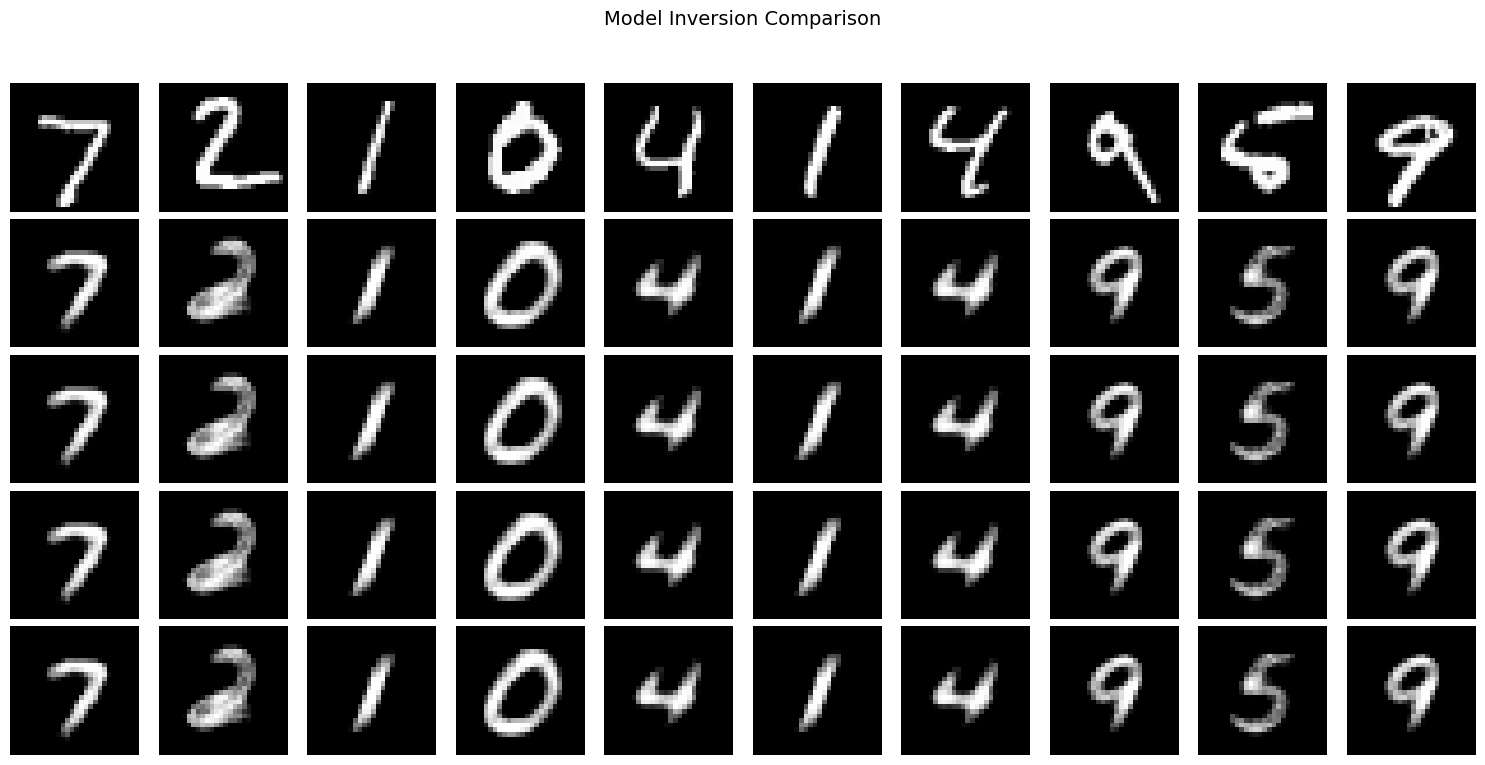

In [17]:
# --- CELL 15: Tái Tạo Ảnh Test và Vẽ Biểu Đồ ---

# Import các thư viện và hàm cần thiết cho cell này
import torch
from phase3_reconstruct import reconstruct_images
from utils import plot_comparison # Hàm vẽ biểu đồ từ utils.py
from attacks.label_only_attack import recover_confidence_vector # Hàm khôi phục vector label-only
# import matplotlib.pyplot as plt # Không cần import lại nếu đã import ở đầu notebook

# --- Phần Khởi tạo và Lấy Dữ liệu ---

# Định nghĩa nhãn cho các hàng trên biểu đồ
method_labels = {
    "label_only": "Label only",
    "vector_based": "Vector-based",
    "score_based": "Score-based",
    "one_hot": "One hot"
}
# Lấy danh sách các phương thức (đảm bảo thứ tự nhất quán với các cell trước)
methods = list(method_labels.keys())

# Khởi tạo dictionary để lưu kết quả tái tạo
results = {}

# !!! SỬA LỖI NameError Ở ĐÂY !!!
# Lấy 10 ảnh/nhãn test gốc (biến `images`, `labels` phải được định nghĩa ở Cell 10)
# Chuyển chúng về CPU và tạo bản sao làm ground truth cho biểu đồ
try:
    images_test_cpu = images.cpu()  # Định nghĩa images_test_cpu
    labels_test_cpu = labels.cpu()  # Định nghĩa labels_test_cpu
    ground_truth_imgs = images_test_cpu.detach().clone() # Định nghĩa ground_truth_imgs
except NameError:
    print("LỖI: Biến 'images' hoặc 'labels' (10 ảnh/nhãn test) chưa được định nghĩa.")
    print("Hãy đảm bảo bạn đã chạy thành công Cell 10.")
    # Gán giá trị tạm để tránh lỗi tiếp theo, nhưng biểu đồ sẽ không đúng
    ground_truth_imgs = None
    images_test_cpu = torch.zeros(10, 1, 28, 28) # Giá trị tạm
    labels_test_cpu = torch.zeros(10, dtype=torch.long) # Giá trị tạm

# Cài đặt device và models (đảm bảo chúng đã được huấn luyện/chuẩn bị ở các cell trước)
device_reconstruct = 'cuda' if torch.cuda.is_available() else 'cpu'
try:
    target_model.to(device_reconstruct).eval()
    # shadow_model nên ở trên CPU theo hàm recover_confidence_vector
    shadow_model.cpu().eval()
except NameError:
    print("LỖI: `target_model` hoặc `shadow_model` chưa được định nghĩa/huấn luyện.")
    # Xử lý lỗi hoặc thoát

# Lấy mu, sigma từ Cell 11 (cần cho 'label_only')
try:
    # Giả sử biến mu và sigma tồn tại từ Cell 11
    mu_for_recon = mu
    sigma_for_recon = sigma
    print(f"Sử dụng mu={mu_for_recon:.4f}, sigma={sigma_for_recon} để tái tạo label_only.")
except NameError:
     print("LỖI: Biến `mu` và `sigma` không tìm thấy từ Cell 11. Không thể tái tạo cho label_only.")
     mu_for_recon = 0.5 # Gán giá trị tạm để tránh lỗi, nhưng kết quả label_only sẽ sai
     sigma_for_recon = 0.1

# --- Phần Tái Tạo Ảnh ---
print("\nĐang tái tạo ảnh thử nghiệm...")

# Lặp qua từng phương pháp tấn công
for method in methods:
    print(f" Đang tái tạo cho: {method}")

    # Lấy attack model đã huấn luyện tương ứng (từ Cell 12)
    # attack_models là dictionary chứa các model đã train
    attack_model_method = attack_models.get(method)

    # Kiểm tra xem model có tồn tại không (trường hợp huấn luyện lỗi)
    if attack_model_method is None:
        print(f"  Bỏ qua {method} vì attack model chưa được huấn luyện.")
        label_name = method_labels[method] # Lấy nhãn đúng
        # Tạo ảnh đen hoặc placeholder nếu model không có
        results[label_name] = torch.zeros_like(images_test_cpu)
        continue

    # Chuyển model sang device và chế độ eval
    attack_model_method = attack_model_method.to(device_reconstruct).eval()
    vectors_to_reconstruct_list = [] # List để lưu vector của 10 ảnh test

    # Tạo vector tin cậy cho từng ảnh test theo phương pháp 'method'
    with torch.no_grad(): # Không cần tính gradient ở bước này
        for i in range(len(images_test_cpu)): # Lặp qua 10 ảnh test
            img_test_device = images_test_cpu[i].unsqueeze(0).to(device_reconstruct) # Thêm batch dim=1 và chuyển sang device
            label_test = labels_test_cpu[i].item() # Lấy nhãn dạng số nguyên

            # Tạo vector test dựa trên phương pháp
            if method == "label_only":
                 vec_test = recover_confidence_vector(
                     shadow_model, mu_for_recon, label_test,
                     num_classes=10, sigma=sigma_for_recon
                 ) # Hàm này trả về CPU
            elif method == "vector_based":
                 vec_test = torch.softmax(target_model(img_test_device), dim=1).squeeze().cpu()
            elif method == "score_based":
                 prob_sb = torch.softmax(target_model(img_test_device), dim=1).squeeze().cpu()
                 max_idx_sb = torch.argmax(prob_sb)
                 vec_test = torch.zeros_like(prob_sb)
                 if 0 <= max_idx_sb < len(vec_test):
                     vec_test[max_idx_sb] = prob_sb[max_idx_sb]
                 else: # Xử lý trường hợp index lỗi (dù hiếm)
                      vec_test[0] = 1.0 # Hoặc xử lý khác
            elif method == "one_hot":
                 pred_oh = torch.argmax(target_model(img_test_device), dim=1).item()
                 vec_test = torch.zeros(10) # Kích thước num_classes
                 if 0 <= pred_oh < 10: # Kiểm tra index hợp lệ
                     vec_test[pred_oh] = 1.0
                 else: # Xử lý trường hợp index lỗi
                      vec_test[0] = 1.0 # Hoặc xử lý khác

            vectors_to_reconstruct_list.append(vec_test.cpu()) # Đảm bảo mọi vector đều ở CPU

    # Ghép các vector thành một batch và chuyển sang device để tái tạo
    vecs_to_reconstruct = torch.stack(vectors_to_reconstruct_list).to(device_reconstruct)

    # Tái tạo ảnh bằng attack model tương ứng
    with torch.no_grad():
        recon = reconstruct_images(attack_model_method, vecs_to_reconstruct)

    # Lưu kết quả vào dictionary với nhãn ngắn gọn làm key
    label_name = method_labels[method]
    results[label_name] = recon.cpu().detach() # Chuyển kết quả về CPU và detach khỏi graph

# --- Phần Vẽ Biểu Đồ ---
print("\nĐang vẽ biểu đồ so sánh...")

if ground_truth_imgs is not None:
    # Kiểm tra xem có đủ kết quả cho các phương pháp không
     if len(results) == len(methods):
         plot_comparison(ground_truth_imgs, results, title='Model Inversion Comparison')
     else:
          # In cảnh báo nếu số lượng kết quả không khớp số phương pháp
          print(f"Warning: Number of results ({len(results)}) does not match number of methods ({len(methods)}). Plot might be incomplete.")
          # Vẫn vẽ với những gì có được
          plot_comparison(ground_truth_imgs, results, title='Model Inversion Comparison (Incomplete)')

else:
    print("Không thể lấy ảnh gốc để vẽ biểu đồ.")

# --- Kết thúc Cell 15 ---